In [1]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff
using Optim

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
Random.seed!(1234)

function toy_PoissonLDS()
    T = 100
    # create a PLDS model
    x0 = [1.0, -1.0]
    p0 = Matrix(Diagonal([0.00001, 0.00001]))
    A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
    Q = Matrix(Diagonal([0.00001, 0.00001]))
    C = [0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2
    log_d = log.([0.1, 0.1, 0.1])

    plds = PoissonLDS(A=A, C=C, Q=Q, log_d=log_d, x0=x0, p0=p0, refractory_period=1, obs_dim=3, latent_dim=2)
    # sample data
    x, y = SSM.sample(plds, T, 1)
    return plds, x, y
end

# plds, x, y_array = toy_PoissonLDS()
# plds.fit_bool = [true, true, true, true, true, true]
x0 = [1.0, -1.0]
p0 = Matrix(Diagonal([0.00001, 0.00001]))
A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
Q = Matrix(Diagonal([0.00001, 0.00001]))
C = [0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2
log_d = log.([0.1, 0.1, 0.1])

plds = PoissonLDS(;A=A, Q=Q, C=C, log_d=log_d, x0=x0, P0=p0, obs_dim=3, latent_dim=2)
x, y = SSM.sample(plds, 100, 1)

([0.9988624373142353 1.0961664982161545 … -1.2244786796090608 -1.2705184656598685;;; -0.9965619448724478 -0.8918205120989873 … 0.5415991085659865 0.4172112876557193], [1.0 2.0 … 0.0 1.0;;; 2.0 1.0 … 0.0 1.0;;; 3.0 2.0 … 0.0 0.0])

In [3]:
C, log_d = plds.obs_model.C, plds.obs_model.log_d
E_z, E_zz, E_zz_prev, x_smooth, P_smooth = SSM.estep(plds, y)

function f(params::AbstractVector{<:Real})
    C_size = plds.obs_dim * plds.latent_dim
    log_d = params[end-plds.obs_dim+1:end]
    C = reshape(params[1:C_size], plds.obs_dim, plds.latent_dim)
    return -SSM.Q_observation_model(C, log_d, E_z, P_smooth, y)
end

params = vcat(vec(C), log_d)
grad = ForwardDiff.gradient(f, params)

9-element Vector{Float64}:
  38.63882251919702
  51.851718085428516
  -8.080715588087921
  14.436878294073239
  27.73770273392614
 -32.177813187089725
   2.6915592269123905
   2.7915592269123928
  -1.9084407730876096

In [4]:
SSM.gradient_observation_model!(zeros(9), C, log_d, E_z, P_smooth, y)

9-element Vector{Float64}:
  38.638822519197035
  51.851718085428516
  -8.080715588087921
  14.436878294073239
  27.73770273392614
 -32.17781318708973
   2.6915592269123914
   2.791559226912395
  -1.9084407730876105

In [14]:
using CSV
using DataFrames

# export a dataframe for each trial
for i in 1:3
    df = DataFrame(y[i, :, :], :auto)
    CSV.write("trial$i.csv", df)
end

In [3]:
E_z, E_zz, E_zz_prev, x_smooth, p_smooth = SSM.estep(plds, y)
SSM.mstep!(plds, E_z, E_zz, E_zz_prev, p_smooth, y)

3-element Vector{Float64}:
 -1.7289236895912088
 -2.523573233149269
 -1.3600503998432614

In [4]:
exp.(plds.obs_model.log_d)

3-element Vector{Float64}:
 0.17747532574953478
 0.08017261885819617
 0.2566478416165983

In [6]:
plds.obs_model.C

3×2 Matrix{Float64}:
 1.10006  1.1578
 1.10262  1.25977
 1.15022  1.09091

In [19]:
plds.state_model.P0

2×2 Matrix{Float64}:
 9.91667e-6  8.41267e-8
 8.41267e-8  1.00431e-5

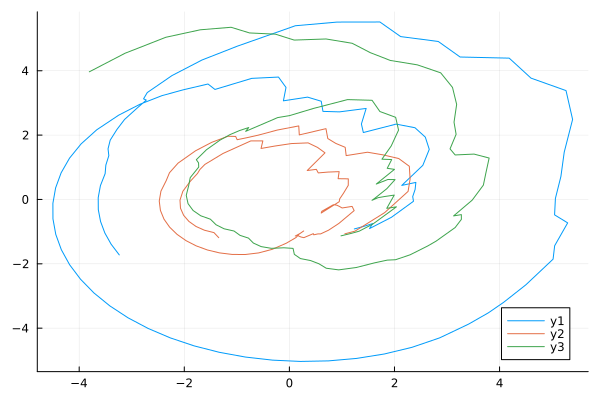

In [6]:
plot(x_smooth[1, :, 1], x_smooth[1, :, 2])
plot!(x_smooth[2, :, 1], x_smooth[2, :, 2])
plot!(x_smooth[3, :, 1], x_smooth[3, :, 2])


In [44]:
"""
    mutable struct PoissonPCA end
A probabilsitic (PCA?) model for Poisson distributed data.
# Fields
- `C::Matrix{<:Real}`: The loading matrix
- `log_d::Vector{<:Real}`: The log bias vector
- `latent_dim::Int64`: The latent dimensionality
- `obs_dim::Int64`: The observation dimensionality
"""
mutable struct PoissonPCA 
    C::Matrix{<:Real}
    log_d::Vector{<:Real}
    latent_dim::Int64
    obs_dim::Int64
end

"""
    PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), d::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
Constructor for PoissonPCA
# Arguments
- `C::Matrix{<:Real}`: The loading matrix
- `log_d::Vector{<:Real}`: The log bias vector
- `latent_dim::Int64`: The latent dimensionality
- `obs_dim::Int64`: The observation dimensionality
"""
function PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), log_d::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
    # initialize C
    if isempty(C)
        C = randn(obs_dim, latent_dim)
    end
    # initialize b
    if isempty(log_d)
        log_d = rand(obs_dim)
    end
    return PoissonPCA(C, log_d, latent_dim, obs_dim)
end

"""
    gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    
Calculate the gradient of the Poisson PCA model. Designed to be passed to LBFGS in Optim.jl.
# Arguments
- `grad::Vector{<:Real}`: The gradient vector
- `x::Vector{<:Real}`: The latent variables
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    T, n = size(y)
    x_mat = reshape(x, T, model.latent_dim)
    d = exp.(model.log_d)
    
    gradient = zeros(T, model.latent_dim)
    for t in 1:T
        λt = exp.(model.C * x_mat[t, :] .+ d)
        gradient[t, :] = model.C' * (y[t, :] - λt)
    end
    
    grad .= -vec(gradient)
end

"""
    hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})

Calculate the Hessian of the Poisson PCA model. Designed to be passed to LBFGS in Optim.jl.

# Arguments
- `hess::Matrix{<:Real}`: The Hessian matrix
- `x::Vector{<:Real}`: The latent variables
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    T, n = size(y)
    k = model.latent_dim
    x_mat = reshape(x, T, k)
    d = exp.(model.log_d)
    
    # Initialize Hessian
    H = zeros(T * k, T * k)
    
    for t in 1:T
        λt = exp.(model.C * x_mat[t, :] .+ d)
        H_block = -model.C' * Diagonal(λt) * model.C
        
        # Place the block in the correct position in the Hessian
        start_idx = (t - 1) * k + 1
        end_idx = t * k
        H[start_idx:end_idx, start_idx:end_idx] = H_block
    end
    
    hess .= -H  # Negative because we're working with log-likelihood
end

"""
    loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
Calculate the log-likelihood of the Poisson PCA model.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `x::Matrix{<:Real}`: The latent variables
- `y::Matrix{<:Real}`: The observed data
"""
function loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    d = exp.(model.log_d)
    T = size(y, 1)
    ll = 0.0
    for t in 1:T
        ll += sum(y[t, :] .* (model.C * x[t, :] + model.b)) - sum(exp.(model.C * x[t, :] + d))
    end
    return ll
end

"""
    E_Step(model::PoissonPCA, y::Matrix{<:Real})
E-Step for Poisson PCA. Computes a MAP estimate of the latent variables by optimiizing the log-likelihood w.r.t. the latent variables.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function E_Step(model::PoissonPCA, y::Matrix{<:Real})
    # create an objective function to minimize
    function obj(x)
        x = reshape(x, size(y, 1), model.latent_dim)
        return -loglikelihood_(model, x, y)
    end
    # create a wrapper for gradient
    function grad!(g, x)
        gradient!(g, x, model, y)
    end
    # optimize the objective function
    res = optimize(obj, grad!, vec(rand(size(y, 1), model.latent_dim)), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    return reshape(res.minimizer, size(y, 1), model.latent_dim)
end

function Q_function(model::PoissonPCA, E_z::Matrix{<:Real}, P_sm::Matrix{<:Real}, y::Matrix{<:Real})
    # Calculate the Q function
    Q = 0.0
    for t in axes(y, 1)
        # compute the linear term
        term_1 = 

"""
    M_Step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
M-Step for Poisson PCA
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `x::Matrix{<:Real}`: The latent variables
- `y::Matrix{<:Real}`: The observed data
"""
function M_Step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    # define objective function to minimize
    function obj(params)
        C = reshape(params[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
        b = params[model.latent_dim * model.obs_dim + 1:end]
        return -loglikelihood_(PoissonPCA(C, b, model.latent_dim, model.obs_dim), x, y)
    end
    # optimize the objective function
    res = optimize(obj, vcat(reshape(model.C, model.latent_dim * model.obs_dim), model.b), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    model.C = reshape(res.minimizer[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
    model.b = res.minimizer[model.latent_dim * model.obs_dim + 1:end]
end

"""
    fit!(model::PoissonPCA, y::Matrix{<:Real}, max_iters::Int=100, tol=1e-6)
Fit the Poisson PCA model to the data.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
- `max_iters::Int=100`: The maximum number of iterations
- `tol::Float64=1e-6`: The tolerance for convergence
"""
function fit!(model::PoissonPCA, y::Matrix{<:Real}, max_iters::Int=100, tol=1e-6)
    # set up first ll
    ll_prev = -Inf
    # Go!
    prog = Progress(max_iters; desc="Fitting Poisson PCA...")
    for i in 1:max_iters
        x = E_Step(model, y)
        M_Step!(model, x, y)
        #println("Log-Likelihood at iter $i: $(loglikelihood_(model, x, y))")
        next!(prog)
        # check for convergence
        ll = loglikelihood_(model, x, y)
        if abs(ll - ll_prev) < tol
            #println("Converged after $i iterations")
            finish!(prog)
            break
        end
    end
end

ErrorException: syntax: extra token "the" after end of expression

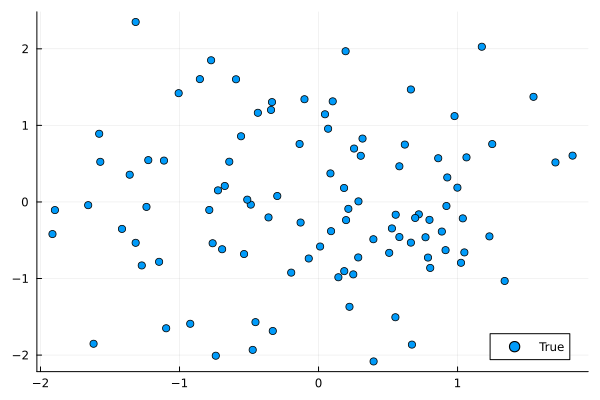

In [66]:
function simulate_poisson_pca(n::Int, T::Int, k::Int; seed=123)
    Random.seed!(seed)
    
    # Generate model parameters
    C = randn(n, k)
    log_d = randn(n)
    d = exp.(log_d)
    
    # Generate latent variables X
    X = randn(T, k)
    
    # Generate observed data Y
    Y = zeros(Int, T, n)
    for t in 1:T
        λ = exp.(C * X[t, :] .+ d)
        Y[t, :] = rand.(Poisson.(λ))
    end
    
    model = PoissonPCA(;C=C, log_d=log_d, latent_dim=k, obs_dim=n)
    return model, X, Y
end

# Simulate data
n, T, k = 10, 100, 2
model, true_X, Y = simulate_poisson_pca(n, T, k)

scatter(true_X[:, 1], true_X[:, 2], label="True")